In [52]:
import os
import math
import numpy as np
import pathlib

from Bio import Entrez
from Bio import SeqIO
from Bio.Align import PairwiseAligner, substitution_matrices
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt


In [3]:
accession_dict = {
    "Human": "NP_001358344.1",
    "Chimpanzee": "NP_001008995.1",
    "Marmoset": "F7CNJ6",
    "Cat": "A0A384DV19",
    "Dog": "J9P7Y2",
    "Ferret": "BAE53380.1",
    "Bat": "ADN93472.1",
    "Pangolin": "XP_017505752.1",
    "Pig": "NP_001116542.1",
    "Mouse": "NP_081562.2",
    "Cattle": "Q58DD0",
}

In [3]:
# To download the sequences
fasta_file = "ace2_orthologs.fasta"
accession_vals = list(accession_dict.values())

# Recommended practice daw na maglagay ng email or sumn but ok
try:
    handle = Entrez.efetch(db="protein", id=accession_vals, rettype="fasta", retmode="text")
    data = handle.read()
    handle.close()
    pathlib.Path(fasta_file).write_text(data)
    print(f"Saved fasta file to {fasta_file}")
except Exception as e:
    print(f"Errror occured: {e}")

c:\Python312\Lib\site-packages\Bio\Entrez\__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


Saved fasta file to ace2_orthologs.fasta


In [4]:
fasta_filename = "ace2_orthologs.fasta"
sequences_dict = {}
try:
    with open(fasta_filename, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            common_name = None
            for name, acc in accession_dict.items():
                if acc in record.id:
                    common_name = name
                    break
            if common_name:
                record.id = common_name
                record.description = f"{common_name} ACE2"
                sequences_dict[common_name] = record

    print(">>> Successfully loaded sequences from file. Verification:")
    print("---------------------------------------------------------")
    for name, record in sequences_dict.items():
        print(f"  - {name:<12} ({accession_dict[name]}): {len(record.seq)} amino acids")
    print("---------------------------------------------------------")

except FileNotFoundError:
    print(f"\n!!! Error: The file '{fasta_filename}' was not found. Please run the download step again.")

>>> Successfully loaded sequences from file. Verification:
---------------------------------------------------------
  - Human        (NP_001358344.1): 805 amino acids
  - Chimpanzee   (NP_001008995.1): 1304 amino acids
  - Ferret       (BAE53380.1): 805 amino acids
  - Bat          (ADN93472.1): 805 amino acids
  - Pangolin     (XP_017505752.1): 805 amino acids
  - Pig          (NP_001116542.1): 805 amino acids
  - Mouse        (NP_081562.2): 805 amino acids
  - Cattle       (Q58DD0): 804 amino acids
---------------------------------------------------------


In [5]:
aligner = PairwiseAligner()
aligner.mode = 'global'
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
# Question: Why these values?
aligner.open_gap_score = -10
aligner.extend_gap_score = -0.5

In [ ]:
print(">>> Performing pairwise alignments against Human ACE2 and analyzing key residues...")
print("-" * 70)
print(f"{'Species':<12} | {'Score':>7} | {'Identity (%)':>12} | {'Pos 31':>7} | {'Pos 35':>7} | {'Pos 41':>7} | {'Pos 42':>7} | {'Pos 82':>7} | {'Pos 353':>7}")
print("-" * 70)


alignments_dict = {}

human_accession = accession_dict["Human"]
human_record = sequences_dict["Human"]

key_residues = {}

for name, record in sequences_dict.items():
    if name == "Human":
        continue # Skip aligning human to itself

    # Perform the global alignment
    # We take the first alignment, which is the one with the optimal score, since aligner.align returns a sorted list of alignments
    alignment = aligner.align(human_record.seq, record.seq)[0]
    alignments_dict[name] = alignment

    # Calculate percent identity
    # (Number of identical sites) / (Length of alignment)
    identity = (np.array(list(alignment[0])) == np.array(list(alignment[1]))).sum()
    percent_identity = (identity / alignment.shape[1]) * 100

    human_aligned_seq = alignment[0]
    other_aligned_seq = alignment[1]
    
    map_human_to_alignment = [i for i, char in enumerate(human_aligned_seq) if char != '-']
    
    # Get the characters at the key positions in the alignment 31, 35, 38, 41, 42, 82, 353
    
    # The key positions are 1-based, Python is 0-based.
    # Position 41 in biology is index 40 in Python.
    key_positions = [31, 35, 38, 41, 42, 82, 353]
    for pos in key_positions:
        if pos - 1 < len(map_human_to_alignment):
            aligned_index = map_human_to_alignment[pos - 1]  # Convert to 0-based index
            key_residues.setdefault(name, {})[pos] = other_aligned_seq[aligned_index]

    common_name = name
    
    print(f"{common_name:<12} | {alignment.score:7.1f} | {percent_identity:11.2f}% | {key_residues[name].get(31, '-'):>7} | {key_residues[name].get(35, '-'):>7} | {key_residues[name].get(41, '-'):>7} | {key_residues[name].get(42, '-'):>7} | {key_residues[name].get(82, '-'):>7} | {key_residues[name].get(353, '-'):>7}")

print(f"{'Human':<12} | {'-':>7} | {'-':>12} | {human_record.seq[30]:>7} | {human_record.seq[34]:>7} | {human_record.seq[40]:>7} | {human_record.seq[41]:>7} | {human_record.seq[81]:>7} | {human_record.seq[352]:>7}")

print("-" * 70)

print ("\nDiscussion Point: For example, Y41 and Q42 in human ACE2 are responsible for the formation of hydrogen bonds with S protein and are highly conserved " \
"\nacross all other species[to paraphrase].")
print("\nExample alignment (Human vs. Bat):")
print(alignments_dict['Bat'])

>>> Performing pairwise alignments against Human ACE2 and analyzing key residues...
----------------------------------------------------------------------
Species      |   Score | Identity (%) |  Pos 31 |  Pos 35 |  Pos 41 |  Pos 42 |  Pos 82 | Pos 353
----------------------------------------------------------------------
Chimpanzee   |  1152.0 |       24.36% |       S |       S |       F |       Q |       G |       R
Ferret       |  3628.0 |       82.61% |       K |       E |       Y |       Q |       T |       K
Bat          |  3515.0 |       80.12% |       K |       K |       H |       Q |       N |       K
Pangolin     |  3679.0 |       84.84% |       K |       E |       Y |       Q |       N |       K
Pig          |  3567.0 |       81.37% |       K |       E |       Y |       Q |       T |       K
Mouse        |  3579.0 |       82.11% |       N |       E |       Y |       Q |       S |       H
Cattle       |  3568.0 |       81.12% |       K |       E |       Y |       Q |       T 

# to do make key residues matrix like this
Our analysis revealed that 80 ACE2 orthologs from 295 species exactly contained the relevant amino acids at positions 31, 35, 38, 82, and 353, which we deduce would allow them to function as SARS-CoV-2 receptors [FROM STUDY]

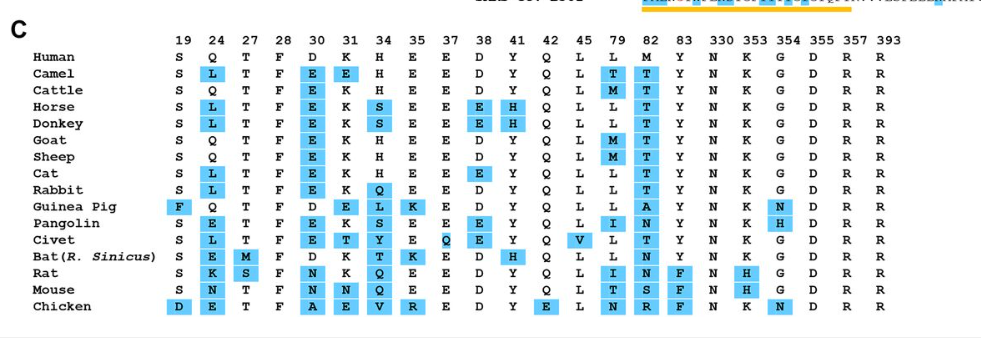



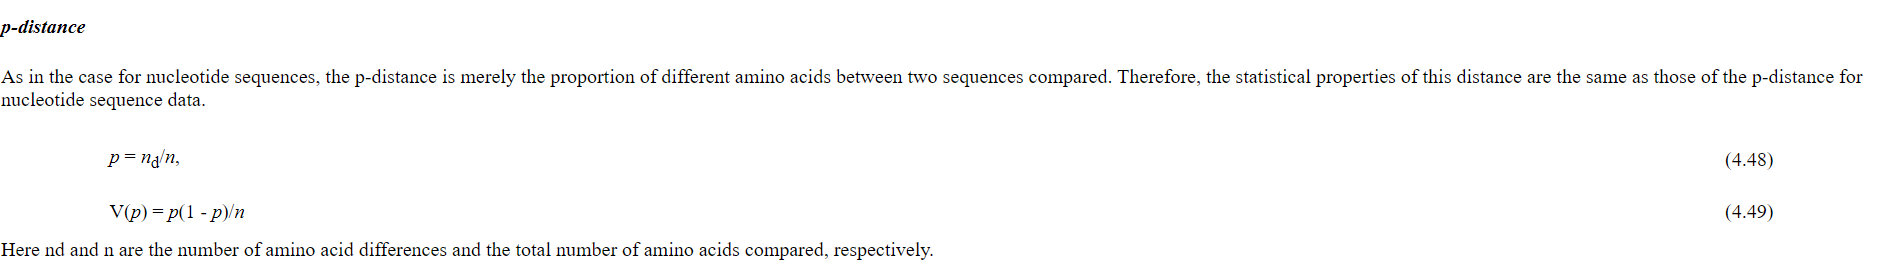

In [7]:
def compute_p_distance(seq1, seq2):
    mismatches = 0
    aligned_len_no_gaps = 0
    for i in range(len(seq1)):
        if seq1[i] != '-' and seq2[i] != '-':
            aligned_len_no_gaps += 1
            if seq1[i] != seq2[i]:
                mismatches += 1
    
    if aligned_len_no_gaps == 0:
        return 0.0

    # p-distance is the proportion of non-identical sites
    p_dist = mismatches / aligned_len_no_gaps
    return p_dist

In [25]:
species_names = list(sequences_dict.keys())
num_species = len(species_names)
human_seq = alignments_dict["Human"][0]  # Human side of the alignment

print("\nP-distance to Human:")
print("-" * 30)
print(f"{'Species':<12} | {'p-distance':>10}")
print("-" * 30)

for species in species_names:
    if species == "Human":
        continue
    # aligned sequences from the alignment Human vs species
    aligned_human = alignments_dict[species][0]
    aligned_other = alignments_dict[species][1]

    p_dist = compute_p_distance(aligned_human, aligned_other)
    print(f"{species:<12} | {p_dist:10.4f}")




P-distance to Human:
------------------------------
Species      | p-distance
------------------------------
Chimpanzee   |     0.5772
Ferret       |     0.1739
Bat          |     0.1988
Pangolin     |     0.1516
Pig          |     0.1863
Mouse        |     0.1789
Cattle       |     0.1878


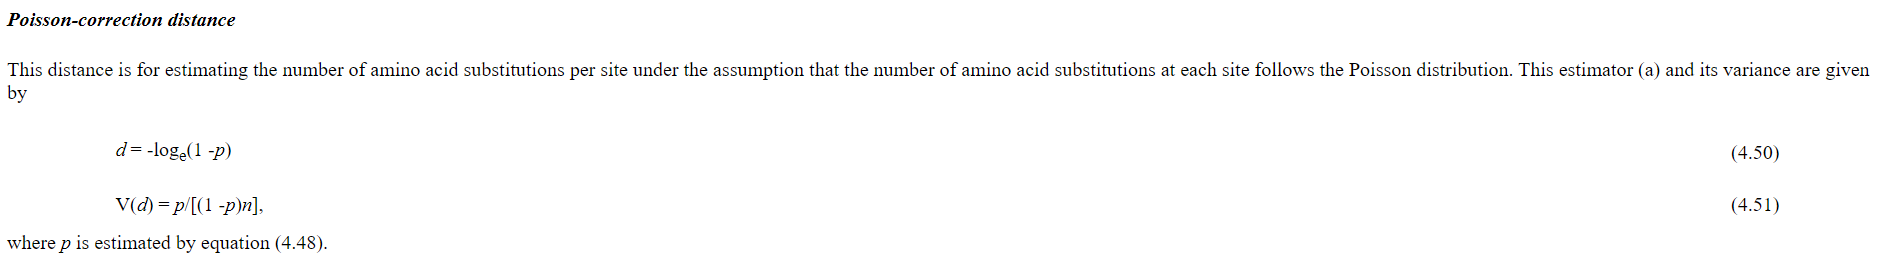

In [26]:
def compute_poisson_distance(seq1, seq2):
    p_dist = compute_p_distance(seq1, seq2)
    if p_dist >= 1.0:
        return float('inf')  # Avoid log(0) or negative values
    return -math.log(1 - p_dist)


In [29]:
species_names = list(sequences_dict.keys())
num_species = len(species_names)
human_seq = alignments_dict["Human"][0]

print("\nPoisson corrected distance to Human:")
print("-" * 30)
print(f"{'Species':<12} | {'p-distance':>10}")
print("-" * 30)

for species in species_names:
    if species == "Human":
        continue
    aligned_human = alignments_dict[species][0]
    aligned_other = alignments_dict[species][1]

    p_dist = compute_poisson_distance(aligned_human, aligned_other)
    print(f"{species:<12} | {p_dist:10.4f}")




Poisson corrected distance to Human:
------------------------------
Species      | p-distance
------------------------------
Chimpanzee   |     0.8608
Ferret       |     0.1911
Bat          |     0.2216
Pangolin     |     0.1643
Pig          |     0.2062
Mouse        |     0.1971
Cattle       |     0.2080


to do a dendogram, you need pairwise sequence alignment of all-all, not just one species-human

In [47]:

distances = np.zeros((num_species, num_species))  # initialize full matrix

for i in range(num_species):
    for j in range(i):  # only compute for lower triangle
        species1 = species_names[i]
        species2 = species_names[j]

        record1 = sequences_dict[species1]
        record2 = sequences_dict[species2]

        alignment = aligner.align(record1.seq, record2.seq)[0]
        corrected_distance = compute_poisson_distance(alignment[0], alignment[1])

        distances[i][j] = corrected_distance
        distances[j][i] = corrected_distance  # mirror


TO DO: NOT SURE IF THIS IS CORRECT
Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

WIKIPEDIA REFERENCE PROVIDED BY DOC:
https://en.wikipedia.org/wiki/UPGMA

In [49]:
condensed = squareform(distances)

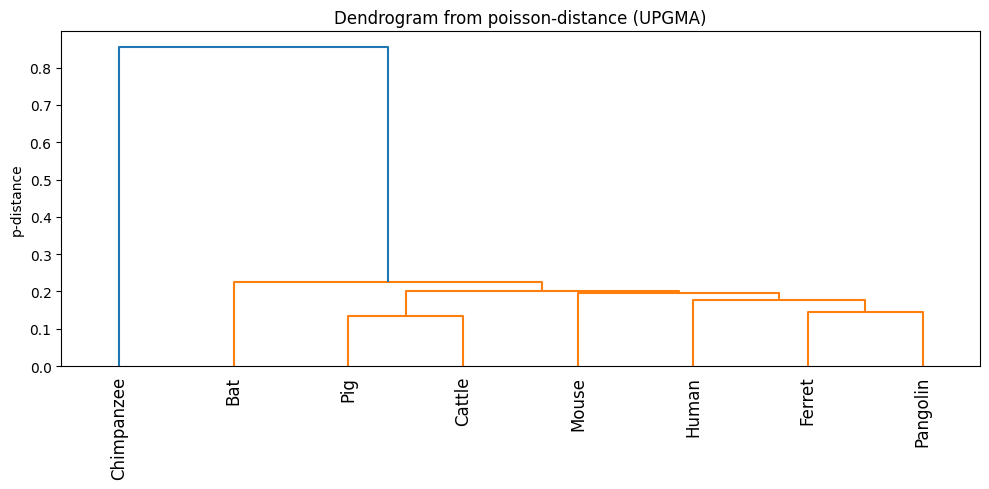

In [53]:
linkage_matrix = linkage(condensed, method='average')  # UPGMA

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=species_names, leaf_rotation=90)
plt.title("Dendrogram from poisson-distance (UPGMA)")
plt.ylabel("p-distance")
plt.tight_layout()
plt.show()


POSSIBLE REFERENCE CODE I SAW
https://github.com/Ahmedhany750/Phylogenetic-Analysis-and-Protein-Sequence-Alignment-Pipeline/blob/main/phylogenetic_analysis_and_protein_sequence_alignment_pipeline.py

In [ ]:
# # Calculate the distance matrix:
# from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# calculator = DistanceCalculator("identity")
# distance_matrix = calculator.get_distance(alignment)
# print(distance_matrix)

# # Build the UPGMA tree
# constructor = DistanceTreeConstructor()
# upgma_tree = constructor.upgma(distance_matrix)

# # Function to assign custom labels to internal nodes
# def label_internal_nodes(tree):
#     counter = 1
#     for clade in tree.find_clades():
#         if clade.name is None:
#             clade.name = f"Node{counter}"
#             counter += 1

# # Label the internal nodes
# label_internal_nodes(upgma_tree)

# # Enhanced Visualization for UPGMA Tree with Custom Labels
# import matplotlib.pyplot as plt
# from Bio import Phylo

# print("UPGMA Tree:")
# fig = plt.figure(figsize=(16, 10))
# ax = fig.add_subplot(1, 1, 1)
# Phylo.draw(upgma_tree, do_show=False, axes=ax)
# plt.title("UPGMA Tree of Protein Sequences with Node Labels", fontsize=16, fontweight="bold")
# plt.xlabel("Branch Length", fontsize=12)
# plt.ylabel("Taxa", fontsize=12)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(color="gray", linestyle="--", linewidth=0.5)
# plt.savefig("upgma_tree_custom_labels.png", dpi=300, bbox_inches="tight")
# plt.show()

# # Print the tree with labels in ASCII format
# Phylo.draw_ascii(upgma_tree)

# # Build the Neighbor Joining (NJ) tree
# nj_tree = constructor.nj(distance_matrix)

# # Enhanced Visualization for NJ Tree
# print("Neighbor Joining Tree:")
# fig = plt.figure(figsize=(16, 10))
# ax = fig.add_subplot(1, 1, 1)
# Phylo.draw(nj_tree, do_show=False, axes=ax)
# plt.title("Neighbor Joining Tree of Protein Sequences", fontsize=16, fontweight="bold")
# plt.xlabel("Branch Length", fontsize=12)
# plt.ylabel("Taxa", fontsize=12)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(color="gray", linestyle="--", linewidth=0.5)
# plt.savefig("nj_tree_stylized.png", dpi=300, bbox_inches="tight")
# plt.show()

# # Save the trees in Newick format
# Phylo.write(upgma_tree, "upgma_tree.nwk", "newick")
# Phylo.write(nj_tree, "nj_tree.nwk", "newick")